In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

In [3]:
df = pd.read_csv("LoanData.csv")
df.head()

,LoanId,NewCreditCustomer,LoanDate,VerificationType,Age,Gender,Country,AppliedAmount,Amount,Interest,...,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,Rating,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,False,2022-09-09,By Bank Statement,27,Female,EE,3189.0,3189.0,35.48,...,UpTo5Years,Other,900.0,0,0.00,0,D,1.0,3402.0,0.0
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,False,2023-05-19,By Bank Statement,35,Female,FI,4146.0,4146.0,19.86,...,UpTo5Years,Owner,3100.0,0,0.00,0,B,1.0,518.0,0.0
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,False,2024-02-03,By Bank Statement,23,Male,EE,531.0,531.0,19.52,...,UpTo5Years,TenantFurnished,1700.0,0,0.00,0,B,3.0,1593.0,0.0
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,False,2016-03-23,By Bank Statement,53,Female,EE,2125.0,2125.0,20.97,...,MoreThan5Years,Owner,354.0,8,485.09,6,C,1.0,500.0,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,False,2023-09-26,By Bank Statement,43,Male,FI,414.0,414.0,19.89,...,Other,TenantFurnished,1200.0,0,0.00,0,D,5.0,11198.0,0.0


In [4]:
# LoanId is unique
df.set_index("LoanId", inplace=True)

Analyzing interest rates and rating distributions to understand overall lending patterns.

In [5]:
interest_mean = df["Interest"].mean() #sample mean
interest_std = df["Interest"].std()  #sample standard deviation

num_less_amount = (df["Amount"] < df["AppliedAmount"]).sum()
#proportion of loan ratings
rating_proportion = df["Rating"].value_counts() / len(df)

In [6]:
print("Interest rate mean:", round(interest_mean, 2))
print("Interest rate standard deviation:", round(interest_std,2))
print("Number of borrowers that received less money than they asked for:", num_less_amount)
print("Proportion of loan ratings:\n", rating_proportion.sort_index())

Interest rate mean: 27.29
Interest rate standard deviation: 18.03
Number of borrowers that received less money than they asked for: 10543
Proportion of loan ratings:
 Rating
A     0.043291
AA    0.024826
B     0.179124
C     0.317741
D     0.206457
E     0.115707
F     0.074443
HR    0.038411
Name: count, dtype: float64


Flagging high-risk customers based on debt-to-income ratio and short job duration to assess their impact on interest rates.

In [8]:
df["DebtToIncome"] = df["Amount"] / df["IncomeTotal"]

df["IsRisky"] = (df["DebtToIncome"] >= 0.35) & \
                (df["EmploymentDurationCurrentEmployer"].isin(["TrialPeriod", "UpTo1Year"]))

# proportion of risky loans
risky_proportion = df["IsRisky"].mean()
mean_interest_risky = df[df["IsRisky"] == True]["Interest"].mean()
# non-risky loans
mean_interest_non_risky = df[df["IsRisky"] == False]["Interest"].mean()

In [9]:
print("Risky loans proportion:", round(risky_proportion, 4))
print("Mean interest rate of risky loans:", round(mean_interest_risky, 4))
print("Mean interest rate of non-risky loans:", round(mean_interest_non_risky, 4))

Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899


Visualizing the relationship between education level and interest rates to identify segmentation patterns 

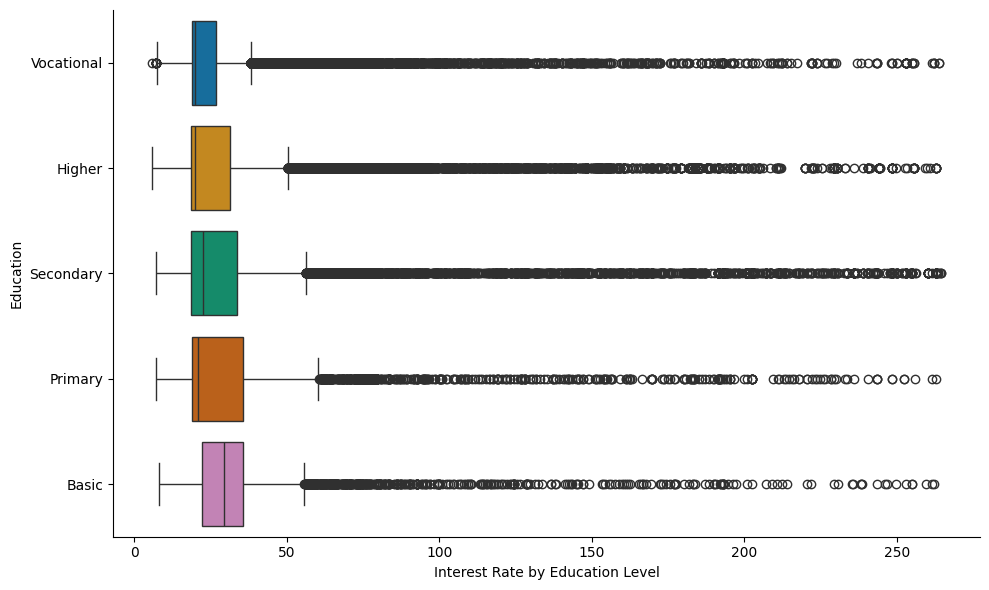

In [10]:
plt.figure(figsize=(10,6))

# segmentation plot
boxplot_ax = sns.boxplot(data=df,
                         x="Interest", 
                         y="Education", 
                         hue="Education",          # Set hue to Education
                         palette="colorblind")

plt.xlabel("Interest Rate")
plt.xlabel("Interest Rate by Education Level")
sns.despine()

plt.tight_layout()
plt.show()

Relationship between interest rates and various numerical features using scatter plots and calculating their correlations.

Correlation between Interest Rate and LoanDuration:
-0.0106
Correlation between Interest Rate and IncomeTotal:
-0.0122
Correlation between Interest Rate and AmountOfPreviousLoansBeforeLoan:
-0.175
Correlation between Interest Rate and DebtToIncome:
-0.0053


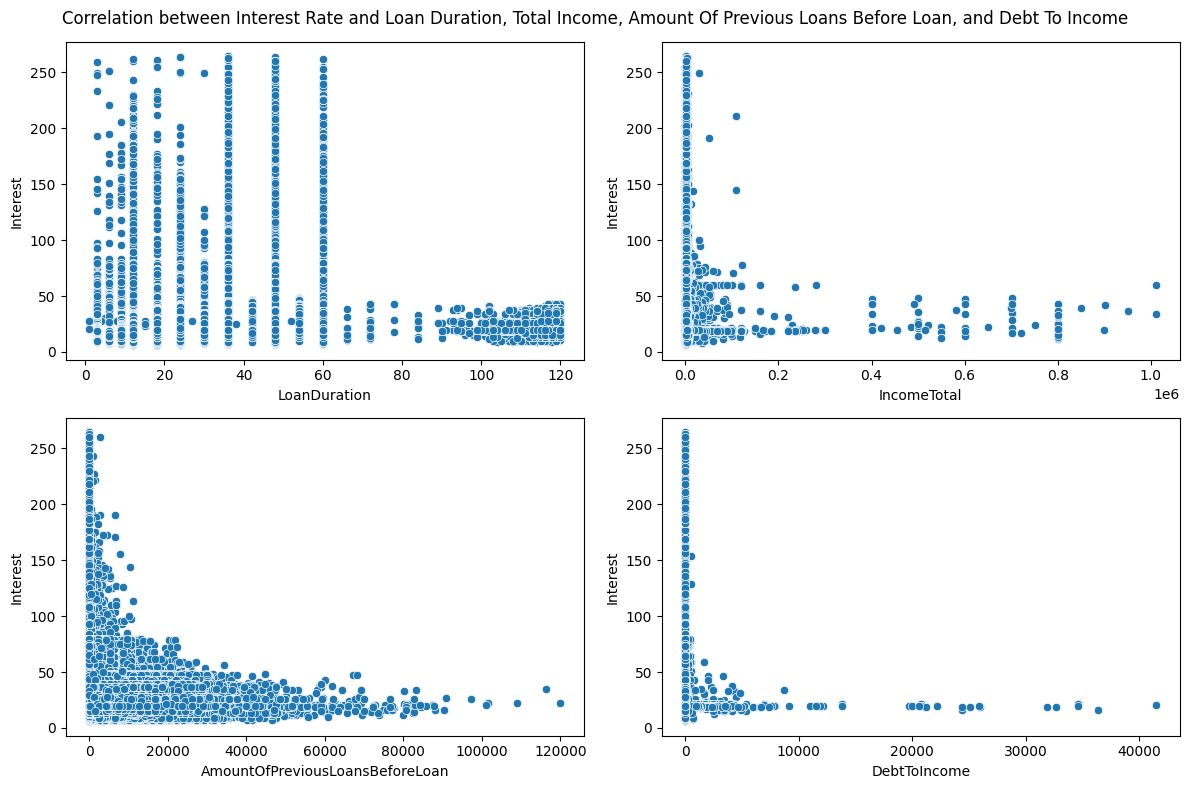

In [11]:
scatterplot_fig = plt.figure(figsize=(12, 8))

correlation = []
corr_columns = ["LoanDuration", "IncomeTotal", "AmountOfPreviousLoansBeforeLoan", 
               "DebtToIncome"]

for i in range(1,5):
    column_name = corr_columns[i-1]
    plt.subplot(2, 2, i) #(rows, columns, index)

    sns.scatterplot(data=df, x=column_name, y="Interest")
    corr = df[column_name].corr(df["Interest"])
    correlation.append(corr)

    print("Correlation between Interest Rate and " + column_name + ":\n"+ str(round(corr,4))) 

scatterplot_fig.suptitle("Correlation between Interest Rate and Loan Duration, Total Income, Amount Of Previous Loans Before Loan, and Debt To Income")

plt.tight_layout()
plt.show()

Calculating the 95% confidence interval for the proportion of loans approved for less than the requested amount

In [12]:
# differs from the requested Amount
num_differences = (df["Amount"] < df["AppliedAmount"]).sum()

n = len(df)
phat = num_differences / n
se = sqrt(phat * (1 - phat) / n)

confidence_interval = stats.norm.interval(0.95, loc=phat, scale=se)

In [13]:
print("The 95% confidence interval is", confidence_interval)

The 95% confidence interval is (0.02698232853687249, 0.028017645379482474)


Building and training a simple linear regression model to predict interest rates

In [14]:
# Do not forget to add the constant term
X_simple = sm.add_constant(df["AmountOfPreviousLoansBeforeLoan"])
Y_simple = df["Interest"] # dependent variable

model_simple = sm.OLS(Y_simple, X_simple)
results_simple = model_simple.fit()

print(results_simple.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Fri, 09 May 2025   Prob (F-statistic):               0.00
Time:                        18:36:06   Log-Likelihood:            -1.6468e+06
No. Observations:              383382   AIC:                         3.294e+06
Df Residuals:                  383380   BIC:                         3.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

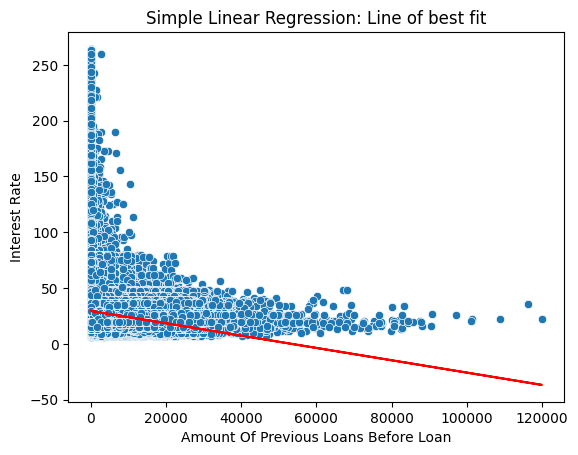

In [15]:
plt.figure()
sns.scatterplot(data=df, x="AmountOfPreviousLoansBeforeLoan", y="Interest")
plt.plot(df["AmountOfPreviousLoansBeforeLoan"], results_simple.predict(X_simple), color="red")
plt.title("Simple Linear Regression: Line of best fit")
plt.xlabel("Amount Of Previous Loans Before Loan")
plt.ylabel("Interest Rate")
plt.show()

Building and refining a more complex linear regression model by including multiple predictors (both numerical and categorical).

In [17]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Define your numerical predictors
predictors = ['Age', 'AppliedAmount', 'Amount', 'LoanDuration', 'IncomeTotal', 
              'ExistingLiabilities', 'LiabilitiesTotal', 'RefinanceLiabilities', 
              'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 
              'PreviousEarlyRepaymentsCountBeforeLoan', 'DebtToIncome', 'Rating']

# Fill missing values with column means
df[predictors] = df[predictors].apply(pd.to_numeric, errors='coerce')  # Coerce anything non-numeric to NaN
df[predictors] = df[predictors].fillna(df[predictors].mean())

# Create X and ensure it's numeric
X = sm.add_constant(df[predictors])
X = X.apply(pd.to_numeric, errors='coerce')

# Create Y and ensure it's numeric
Y = pd.to_numeric(df['Interest'], errors='coerce').fillna(df['Interest'].mean())

# Fit the model
model = sm.OLS(Y, X)
results = model.fit()

# Show summary
print(results.summary())



MissingDataError: exog contains inf or nans